In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import os
import random
import wandb

from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


import warnings

warnings.filterwarnings(action="ignore")

In [39]:
SEED = 42
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(SEED)

In [40]:
dir = "/opt/ml/input/data/" 
train_file_path = os.path.join(dir, "FE_data.csv") 
df = pd.read_csv(train_file_path)

df.sort_values(by=["userID", "Timestamp"], inplace=True)

In [41]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'dataset', 'left_asymptote', 'elo_prob', 'hour', 'dow',
       'elap_time', 'prefix', 'mid', 'suffix', 'test_mean', 'test_sum',
       'tag_mean', 'tag_sum', 'ass_mean', 'ass_sum', 'suffix_mean',
       'suffix_sum', 'hour_mean', 'hour_sum', 'dow_mean', 'dow_sum', 'tag_elp',
       'tag_elp_o', 'tag_elp_x', 'ass_elp', 'ass_elp_o', 'ass_elp_x',
       'suffix_elp', 'suffix_elp_o', 'suffix_elp_x', 'user_correct_answer',
       'user_total_answer', 'user_acc', 'Prefix_o', 'PrefixCount', 'PrefixAcc',
       'PrefixElp', 'PrefixMElp', 'suffix_count', 'tag_count', 'RepeatedTime',
       'prior_KnowledgeTag_frequency'],
      dtype='object')

In [26]:
random.seed(42)

def train_test_split(df, ratio=0.8, split=True):

    df = df[df.dataset == 1]

    users = list(zip(df["userID"].value_counts().index, df["userID"].value_counts()))
    random.shuffle(users)

    max_train_data_len = ratio * len(df)
    sum_of_train_data = 0
    user_ids = []

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)

    train = df[df["userID"].isin(user_ids)]
    test = df[df["userID"].isin(user_ids) == False]

    test = test[test["userID"] != test["userID"].shift(-1)]
    return train, test


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2526700 entries, 0 to 2526699
Data columns (total 52 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   userID                        int64  
 1   assessmentItemID              object 
 2   testId                        int64  
 3   answerCode                    int64  
 4   Timestamp                     object 
 5   KnowledgeTag                  int64  
 6   dataset                       int64  
 7   left_asymptote                int64  
 8   elo_prob                      float64
 9   hour                          int64  
 10  dow                           int64  
 11  elap_time                     float64
 12  prefix                        int64  
 13  mid                           int64  
 14  suffix                        int64  
 15  test_mean                     float64
 16  test_sum                      int64  
 17  tag_mean                      float64
 18  tag_sum               

In [28]:
def feature_engineering(df):
    categories = [
        "assessmentItemID",
    ]  
    le = preprocessing.LabelEncoder()

    for category in categories:
        if df[category].dtypes != "int":  
            df[category] = le.fit_transform(df[category])
        df[category] = df[category].astype("category")
    return df

In [29]:
df = feature_engineering(df)
train, valid = train_test_split(df)

y_train = train["answerCode"]
train = train.drop(["answerCode"], axis=1)
y_valid = valid["answerCode"]
valid = valid.drop(["answerCode"], axis=1)

In [42]:
FEATS = [
    'userID', 
    'assessmentItemID', 
    'testId', 
    #'answerCode', 
    #'Timestamp',
    'KnowledgeTag', 
    #'dataset', 
    'left_asymptote', 
    'elo_prob', 
    'hour', 
    'dow',
    'elap_time', 
    'prefix', 
    'mid', 
    'suffix', 
    'test_mean', 
    'test_sum',
    'tag_mean', 
    'tag_sum', 
    'ass_mean', 
    'ass_sum', 
    'suffix_mean',
    'suffix_sum', 
    'hour_mean', 
    'hour_sum', 
    'dow_mean', 
    'dow_sum', 
    'tag_elp',
    'tag_elp_o', 
    'tag_elp_x', 
    'ass_elp', 
    'ass_elp_o', 
    'ass_elp_x',
    'suffix_elp', 
    'suffix_elp_o', 
    'suffix_elp_x', 
    'user_correct_answer',
    'user_total_answer', 
    'user_acc', 
    'Prefix_o', 
    'PrefixCount', 
    'PrefixAcc',
    'PrefixElp', 
    'PrefixMElp', 
    'suffix_count', 
    'tag_count', 
    'RepeatedTime',
    'prior_KnowledgeTag_frequency'
]

In [43]:
cat_cols = train[FEATS].columns[train[FEATS].dtypes == "category"].to_list()
num_cols = train[FEATS].columns[train[FEATS].dtypes != "category"].to_list()

In [44]:
train_pool = Pool(train[FEATS], y_train, cat_features=cat_cols)
eval_pool = Pool(valid[FEATS], y_valid, cat_features=cat_cols)

In [45]:
params = {
    "random_state":42,
    "iterations": 1500,
    "learning_rate": 0.1, 
    "eval_metric": "AUC",
    "logging_level": "Silent",
    "early_stopping_rounds": 50,
    "use_best_model": True,
    "task_type": "GPU",
    "bagging_temperature": 1,
    "cat_features": cat_cols,
}

model = CatBoostClassifier(
    **params,
)

model.fit(
    train[FEATS],
    y_train,
    eval_set=[(valid[FEATS], y_valid)],
    plot=True,
    logging_level="Verbose"
    # cat_features=cat_cols,
)

preds = model.predict_proba(valid[FEATS])[:, 1]
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f"VALID AUC : {auc} ACC : {acc}\n")


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7678485	best: 0.7678485 (0)	total: 39.6ms	remaining: 59.4s
1:	total: 79.7ms	remaining: 59.7s
2:	total: 120ms	remaining: 60s
3:	total: 159ms	remaining: 59.6s
4:	total: 198ms	remaining: 59.3s
5:	test: 0.7900224	best: 0.7900224 (5)	total: 237ms	remaining: 59.1s
6:	total: 276ms	remaining: 58.8s
7:	total: 315ms	remaining: 58.7s
8:	total: 353ms	remaining: 58.4s
9:	total: 391ms	remaining: 58.2s
10:	test: 0.7967363	best: 0.7967363 (10)	total: 429ms	remaining: 58.1s
11:	total: 468ms	remaining: 58.1s
12:	total: 507ms	remaining: 57.9s
13:	total: 545ms	remaining: 57.8s
14:	total: 583ms	remaining: 57.7s
15:	test: 0.7984822	best: 0.7984822 (15)	total: 621ms	remaining: 57.6s
16:	total: 659ms	remaining: 57.5s
17:	total: 698ms	remaining: 57.5s
18:	total: 736ms	remaining: 57.4s
19:	total: 774ms	remaining: 57.3s
20:	test: 0.7996107	best: 0.7996107 (20)	total: 812ms	remaining: 57.2s
21:	total: 851ms	remaining: 57.2s
22:	total: 889ms	remaining: 57.1s
23:	total: 929ms	remaining: 57.1s
24:	total: 

Text(0.5, 1.0, 'Feature Importance')

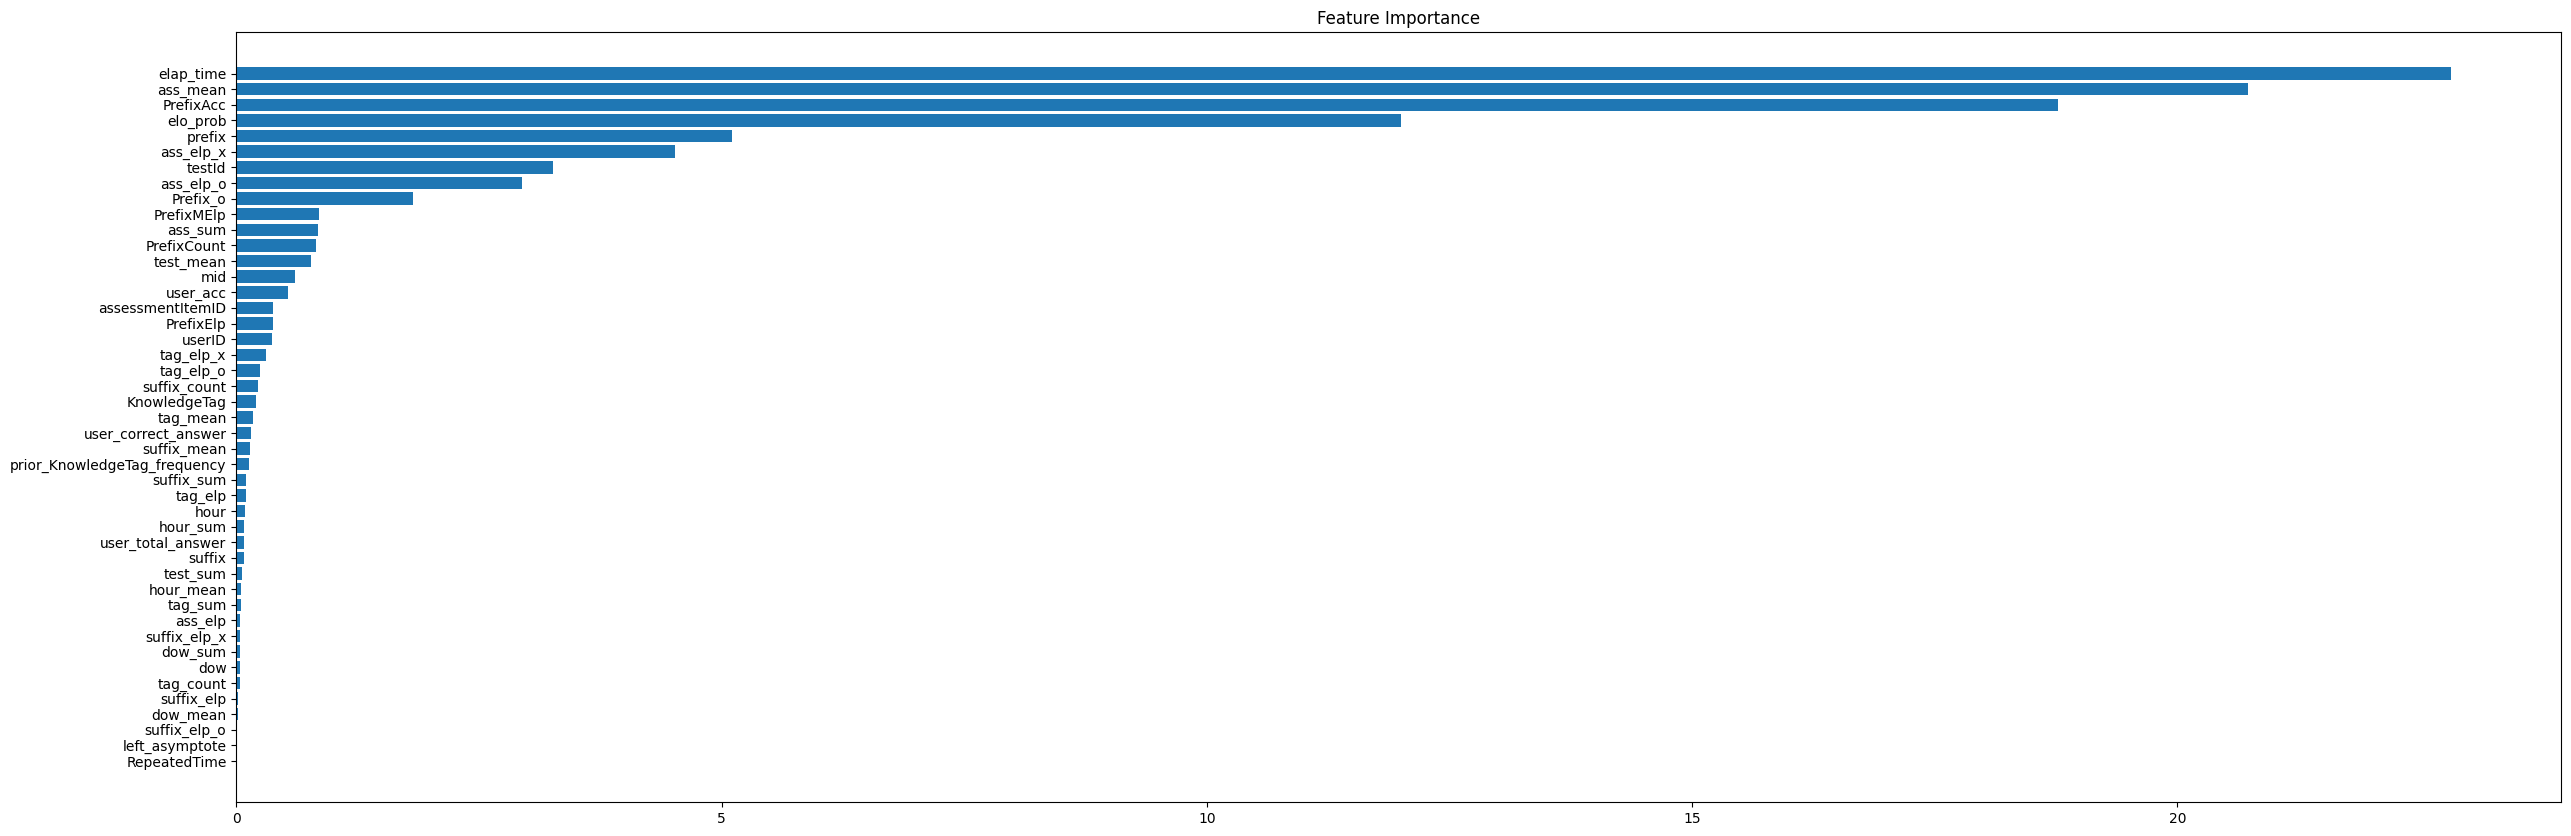

In [46]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(30, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(FEATS)[sorted_idx])
plt.title("Feature Importance")

In [48]:
test = df[(df.dataset == 2) & (df.answerCode != -1)]  # -1 제외
test = test[test["userID"] != test["userID"].shift(-1)]

y_test = test["answerCode"]
test = test.drop(["answerCode"], axis=1)

preds = model.predict_proba(test[FEATS])[:, 1]
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f"VALID AUC : {auc} ACC : {acc}")

VALID AUC : 0.8489133376736429 ACC : 0.782258064516129


# 제출

In [49]:
test_df = df[df.dataset == 2]

test_df = test_df[test_df["userID"] != test_df["userID"].shift(-1)]
test_df = test_df.drop(["answerCode"], axis=1)

total_preds = model.predict_proba(test_df[FEATS])[:, 1]



In [50]:

output_dir = "output/"
write_path = os.path.join(output_dir, "CatBoost_Submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, "w", encoding="utf8") as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write("{},{}\n".format(id, p))

writing prediction : output/CatBoost_submission.csv
